### Linear Regression Task
- 각 광고 종목에 투자했을 때, 수익이 얼만큼 발생하는지 회귀 예측 진행

In [39]:
import pandas as pd

a_df = pd.read_csv('./datasets/advertising.csv')
a_df

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9
...,...,...,...,...,...
195,196,38.2,3.7,13.8,7.6
196,197,94.2,4.9,8.1,9.7
197,198,177.0,9.3,6.4,12.8
198,199,283.6,42.0,66.2,25.5


In [40]:
a_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  200 non-null    int64  
 1   TV          200 non-null    float64
 2   Radio       200 non-null    float64
 3   Newspaper   200 non-null    float64
 4   Sales       200 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 7.9 KB


In [41]:
# Unnamed: 0 컬럼 제거
pre_a_df = a_df.copy()
pre_a_df.drop(labels=['Unnamed: 0'], axis=1, inplace=True)
pre_a_df

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9
...,...,...,...,...
195,38.2,3.7,13.8,7.6
196,94.2,4.9,8.1,9.7
197,177.0,9.3,6.4,12.8
198,283.6,42.0,66.2,25.5


In [42]:
pre_a_df.isna().sum()

TV           0
Radio        0
Newspaper    0
Sales        0
dtype: int64

In [43]:
pre_a_df.duplicated().sum()

0

In [44]:
pre_a_df.corr()['Sales'].sort_values(ascending=False)[1:]

TV           0.782224
Radio        0.576223
Newspaper    0.228299
Name: Sales, dtype: float64

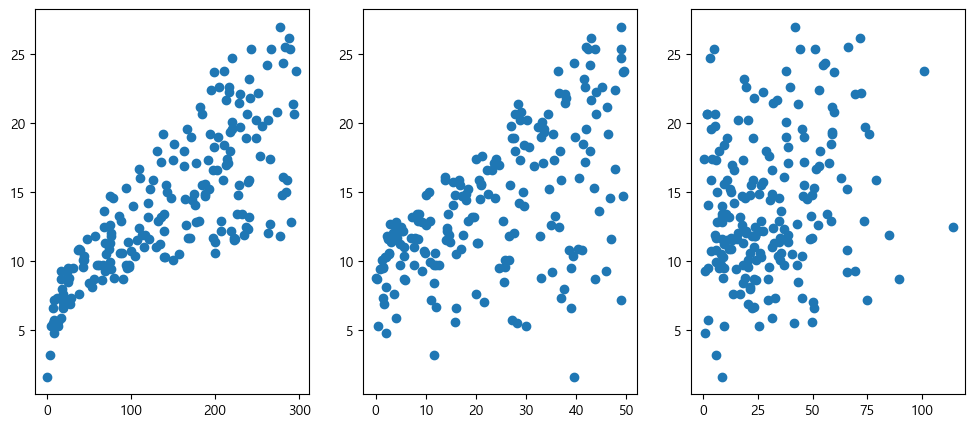

In [45]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(12, 5))
axes[0].scatter(pre_a_df['TV'], pre_a_df['Sales'])
axes[1].scatter(pre_a_df['Radio'], pre_a_df['Sales'])
axes[2].scatter(pre_a_df['Newspaper'], pre_a_df['Sales'])

plt.show()

- 상관관계도 더 높고, 산점도로 시각화해보았을 때에도 분포가 비교적 몰려 있는 TV feature로 단변량 회귀 예측을 진행하기로 합니다.

array([[<Axes: title={'center': 'TV'}>,
        <Axes: title={'center': 'Radio'}>],
       [<Axes: title={'center': 'Newspaper'}>,
        <Axes: title={'center': 'Sales'}>]], dtype=object)

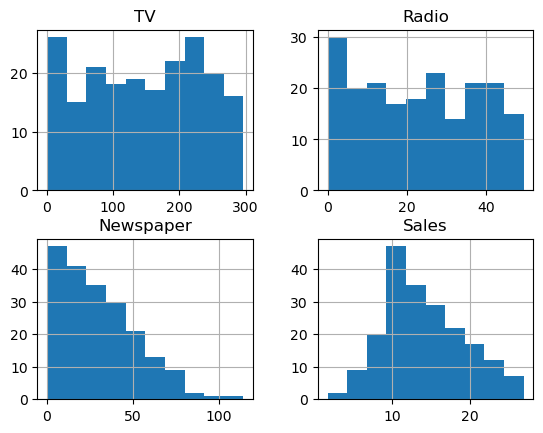

In [8]:
pre_a_df.hist()

- TV feature의 왜도가 높으므로 log1p scaling을 진행해봅니다.

<Axes: >

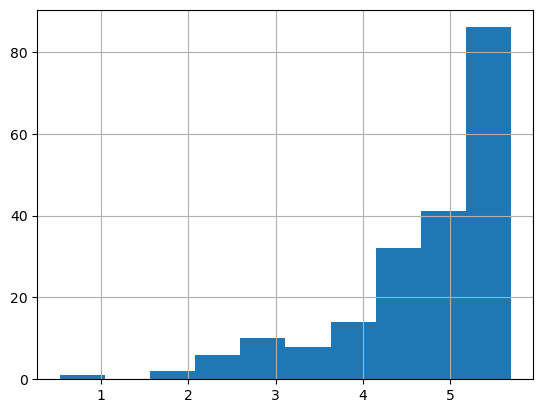

In [10]:
import numpy as np

np.log1p(pre_a_df.TV).hist()

- log1p 스케일링 적용 전의 분포가 더 나으므로 진행하지 않습니다.

In [46]:
pre_a_df = pre_a_df[['TV', 'Sales']]
pre_a_df

,TV,Sales
0,230.1,22.1
1,44.5,10.4
2,17.2,9.3
3,151.5,18.5
4,180.8,12.9
...,...,...
195,38.2,7.6
196,94.2,9.7
197,177.0,12.8
198,283.6,25.5


array([[<Axes: title={'center': 'TV'}>,
        <Axes: title={'center': 'Sales'}>]], dtype=object)

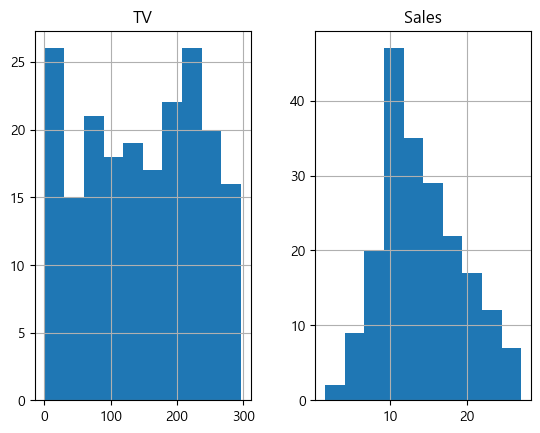

In [47]:
pre_a_df.hist()

In [15]:
# 학습 및 테스트 데이터 분리
from sklearn.model_selection import train_test_split
import torch

features, targets = pre_a_df.iloc[:, :-1], pre_a_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=124)

X_train = torch.FloatTensor(X_train.values)
y_train = torch.FloatTensor(y_train.values).view(-1, 1)

X_test = torch.FloatTensor(X_test.values)
y_test = torch.FloatTensor(y_test.values).view(-1, 1)

In [30]:
from torch.optim import SGD

torch.manual_seed(124)

# 가중치 초기화
W = torch.zeros(1, requires_grad=True)

# 편향 초기화
b = torch.zeros(1, requires_grad=True)

# 경사 하강법을 사용한 optimizer 선언
optimizer = SGD([W, b], lr=1e-5)

# 반복 횟수
epochs = 1500000

for epoch in range(1, epochs + 1):
    H = W * X_train + b
    loss = torch.mean((y_train - H) ** 2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if not epoch % 100000:
        print('{:4d}/{}: W: {:.4f}, b: {:.4f}, loss: {:.4f}'\
              .format(epoch, epochs, W.item(), b.item(), loss.item()))

100000/1500000: W: 0.0698, b: 2.6562, loss: 15.5498
200000/1500000: W: 0.0613, b: 4.3327, loss: 12.6898
300000/1500000: W: 0.0559, b: 5.3911, loss: 11.5502
400000/1500000: W: 0.0525, b: 6.0581, loss: 11.0968
500000/1500000: W: 0.0504, b: 6.4792, loss: 10.9159
600000/1500000: W: 0.0491, b: 6.7463, loss: 10.8435
700000/1500000: W: 0.0482, b: 6.9126, loss: 10.8150
800000/1500000: W: 0.0477, b: 7.0181, loss: 10.8035
900000/1500000: W: 0.0474, b: 7.0800, loss: 10.7992
1000000/1500000: W: 0.0471, b: 7.1277, loss: 10.7970
1100000/1500000: W: 0.0470, b: 7.1502, loss: 10.7963
1200000/1500000: W: 0.0470, b: 7.1502, loss: 10.7963
1300000/1500000: W: 0.0470, b: 7.1502, loss: 10.7963
1400000/1500000: W: 0.0470, b: 7.1502, loss: 10.7963
1500000/1500000: W: 0.0470, b: 7.1502, loss: 10.7963


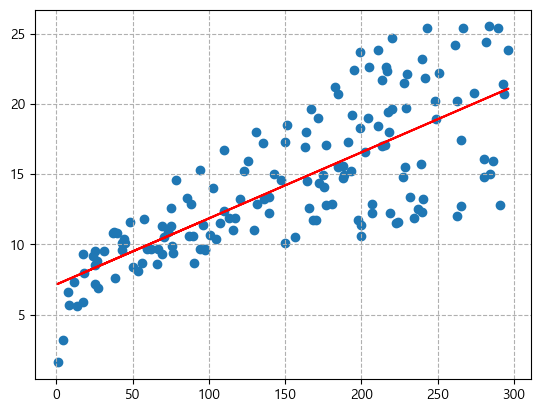

In [31]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

plt.scatter(X_train, y_train)
plt.plot(X_train, 0.0470 * X_train + 7.1502, color="red")
plt.grid(visible=True, linestyle='--')
plt.show()

In [33]:
H = 0.0470 * X_test + 7.1502

print(torch.mean((y_test - H) ** 2).item())

9.395917892456055


In [34]:
# 클래스를 직접 재정의하여 사용
from torch.nn import Module, Linear

class LinearRegressionModel(Module):
    def __init__(self):
        super().__init__()
        self.linear = Linear(1, 1)

    # model(X_train) 호출 시 forward(X_train) 메소드 호출
    def forward(self, x):
        return self.linear(x)

In [35]:
from torch.optim import SGD
from torch.nn.functional import mse_loss

torch.manual_seed(124)

l_r = LinearRegressionModel()

# 경사 하강법을 사용한 optimizer 선언
optimizer = SGD(l_r.parameters(), lr=1e-5)

# 반복 횟수
epochs = 1500000

for epoch in range(1, epochs + 1):
    H = l_r(X_train)
    loss = mse_loss(H, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if not epoch % 100000:
        W = list(l_r.parameters())[0].item()
        b = list(l_r.parameters())[1].item()
        print('{:4d}/{}: W: {:.4f}, b: {:.4f}, loss: {:.4f}'\
              .format(epoch, epochs, W, b, loss.item()))

100000/1500000: W: 0.0689, b: 2.8241, loss: 15.2052
200000/1500000: W: 0.0608, b: 4.4386, loss: 12.5525
300000/1500000: W: 0.0556, b: 5.4574, loss: 11.4960
400000/1500000: W: 0.0523, b: 6.1009, loss: 11.0746
500000/1500000: W: 0.0503, b: 6.5065, loss: 10.9070
600000/1500000: W: 0.0490, b: 6.7619, loss: 10.8403
700000/1500000: W: 0.0482, b: 6.9243, loss: 10.8135
800000/1500000: W: 0.0476, b: 7.0259, loss: 10.8029
900000/1500000: W: 0.0473, b: 7.0839, loss: 10.7989
1000000/1500000: W: 0.0471, b: 7.1316, loss: 10.7969
1100000/1500000: W: 0.0470, b: 7.1502, loss: 10.7963
1200000/1500000: W: 0.0470, b: 7.1502, loss: 10.7963
1300000/1500000: W: 0.0470, b: 7.1502, loss: 10.7963
1400000/1500000: W: 0.0470, b: 7.1502, loss: 10.7963
1500000/1500000: W: 0.0470, b: 7.1502, loss: 10.7963


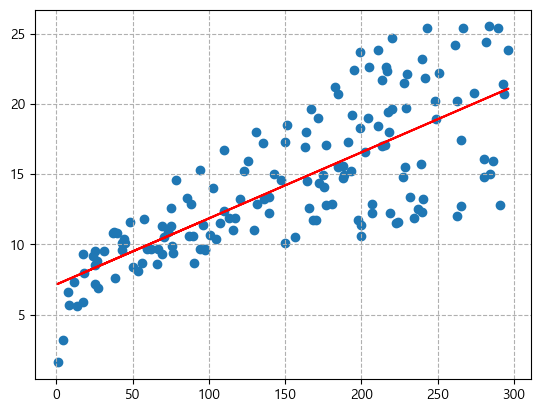

In [36]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

plt.scatter(X_train, y_train)
plt.plot(X_train, 0.0470 * X_train + 7.1502, color="red")
plt.grid(visible=True, linestyle='--')
plt.show()

In [37]:
H = 0.0470 * X_test + 7.1502

print(torch.mean((y_test - H) ** 2).item())

9.395917892456055


### Sklearn - LinearRegression Task

In [48]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

features, targets = pre_a_df.iloc[:, :-1], pre_a_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=124)

l_r = LinearRegression()
l_r.fit(X_train, y_train)
print('W: {:.4f}, b: {:.4f}'.format(l_r.coef_[0], l_r.intercept_))

W: 0.0467, b: 7.2020


In [49]:
prediction = l_r.predict(X_test)
mse = mean_squared_error(y_test, prediction)
print('MSE loss: {:.4f}, RMSE loss: {:.4f}'\
    .format(mse, np.sqrt(mse)))

MSE loss: 9.4174, RMSE loss: 3.0688


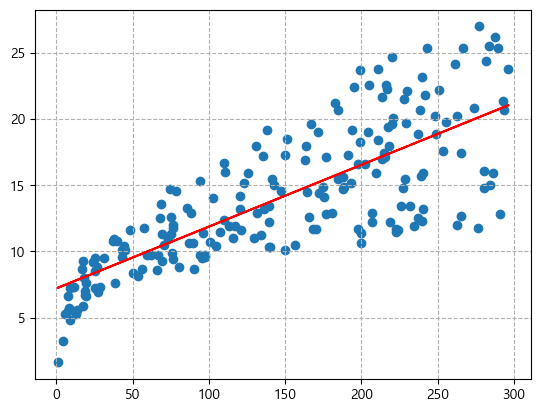

In [51]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

plt.scatter(features.values, targets)
plt.plot(features.values, 0.0467 * features.values + 7.2020, color="red")
plt.grid(visible=True, linestyle='--')
plt.show()